## JUPITER

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord
from collections import defaultdict
import datetime
from utils import *
from astropy.io import ascii

In [2]:
import importlib
plots = importlib.import_module('plots')
importlib.reload(plots)
from plots import *

import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

Total stack (over every ScW)

In [3]:
s_flu, s_var, s_expo, s_flux, s_var_flux, body_i, body_j = stack_images(dir="../data/Jupiter/3-15keV/Images", 
                                                                        table_dir='../data/jupiter_table.dat', 
                                                                        crab_dir="../data/weighted_crab_averages.txt", 
                                                                        centering=False, 
                                                                        test_noise=False)

Failed to open 026700060010.001mosaic.fits: list index out of range
Failed to open 026700070010.001mosaic.fits: list index out of range
Failed to open 026700080010.001mosaic.fits: list index out of range
Failed to open 026700090010.001mosaic.fits: list index out of range
Failed to open 026700100010.001mosaic.fits: list index out of range
Failed to open 026700140010.001mosaic.fits: list index out of range
Failed to open 026700150010.001mosaic.fits: list index out of range
Failed to open 026700370010.001mosaic.fits: list index out of range
Failed to open 026700380010.001mosaic.fits: list index out of range
Failed to open 026700390010.001mosaic.fits: list index out of range
Failed to open 026700400010.001mosaic.fits: list index out of range
Failed to open 026800180010.001mosaic.fits: list index out of range
Failed to open 026800190010.001mosaic.fits: list index out of range
Failed to open 026800200010.001mosaic.fits: list index out of range
Failed to open 026800210010.001mosaic.fits: list

Plotting

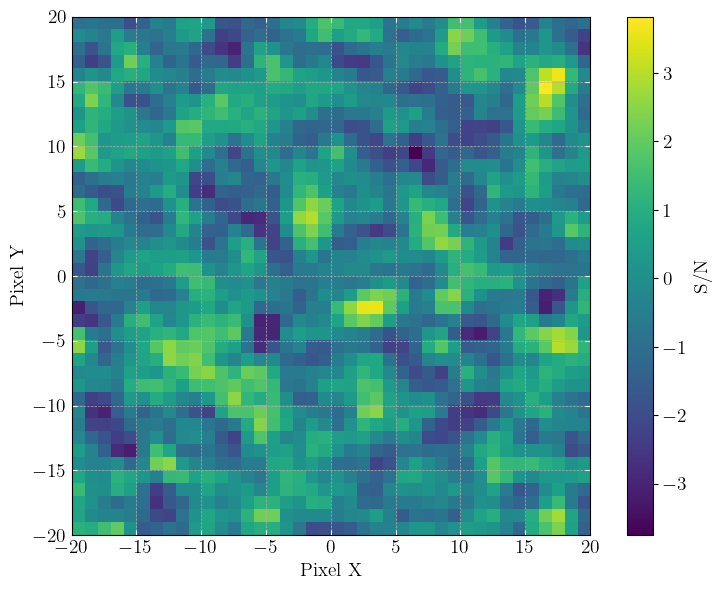

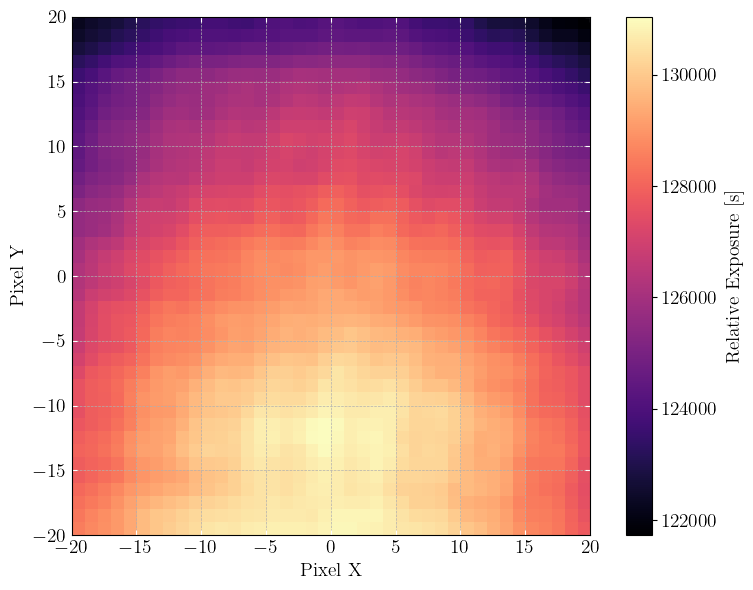

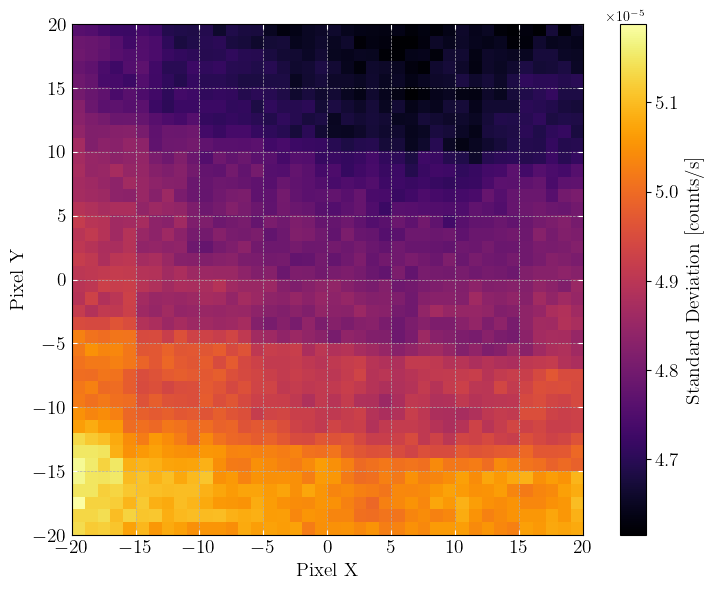

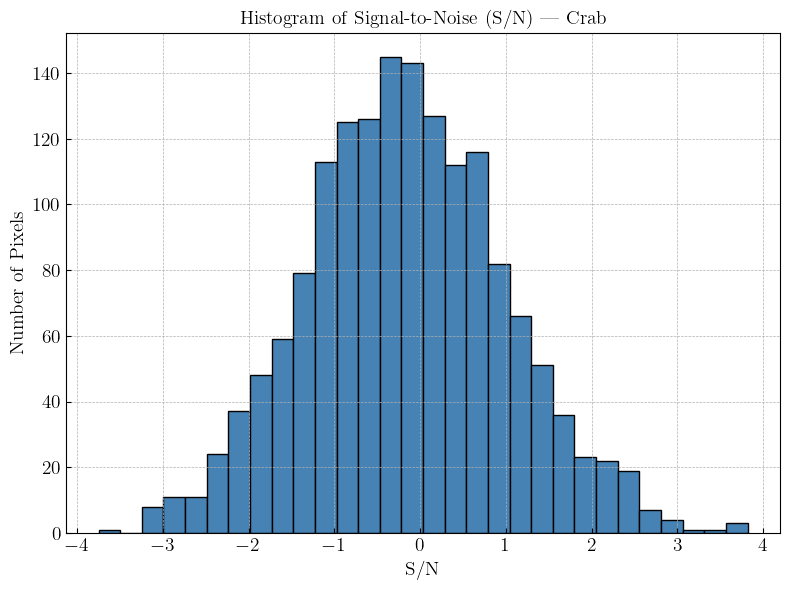

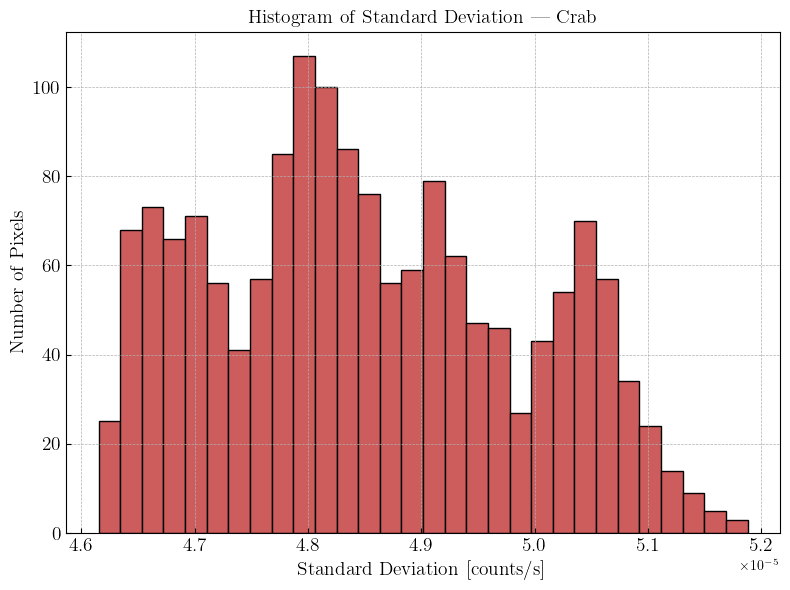

In [5]:
plot_stack(s_flu, s_var, s_expo, 20, save=False, save_name="Jupiter-SNR-map-30-60-keV")

Flux at center: -6.841e-04 ± 1.030e-03 ph/cm²/s
3sigma upper limit at center: 2.405e-03 ph/cm²/s

S/N at the center of the stacked map: -0.23
Probability of observing S/N ≥ -0.23: 57.93%


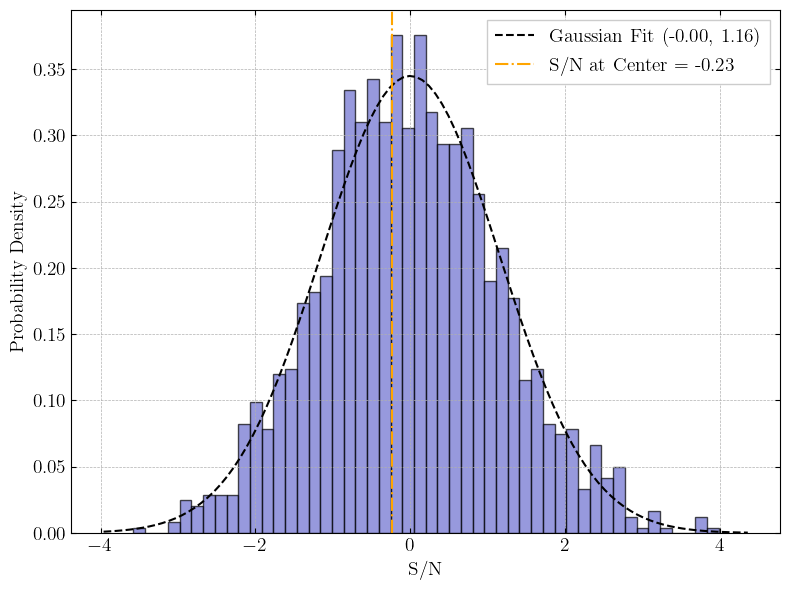

In [89]:
colors = plt.get_cmap('tab20b').colors
stack_statistics(s_flu, s_var, s_expo, s_flux, s_var_flux, body_i, body_j, 20, color=colors[2], linecolors=['k', 'orange'], save=False, save_name="Jupiter-30-60-stack-distribution")

## CRAB

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord
from collections import defaultdict
import datetime
from utils import *
from astropy.io import ascii
from scipy.ndimage import shift


In [43]:
import importlib
plots = importlib.import_module('plots')
importlib.reload(plots)
from plots import *

import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

In [6]:
crab_coords = SkyCoord.from_name("Crab")
crab_ra = crab_coords.ra.deg
crab_dec = crab_coords.dec.deg
print(f"Crab coordinates: RA = {crab_ra}, Dec = {crab_dec}")

Crab coordinates: RA = 83.6324, Dec = 22.0174


Total stacked images: 93
Saved Crab SNR map.
Saved Crab EXP map.
Saved Crab STD map.
S/N at the center of the stacked map: 1236.90
Probability of observing S/N ≥ 1236.90: 0.00%


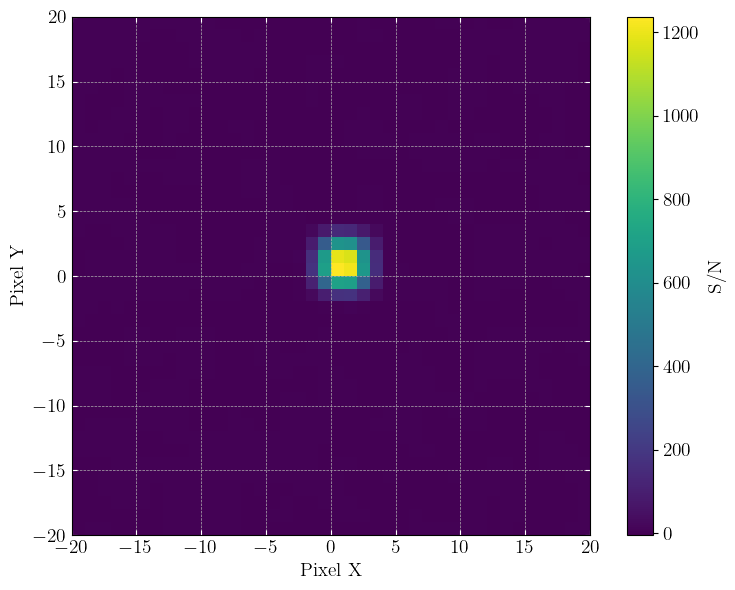

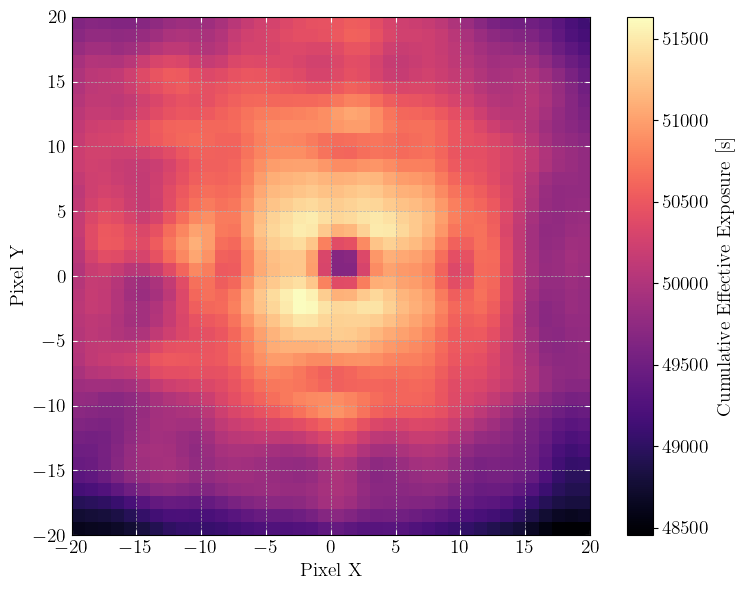

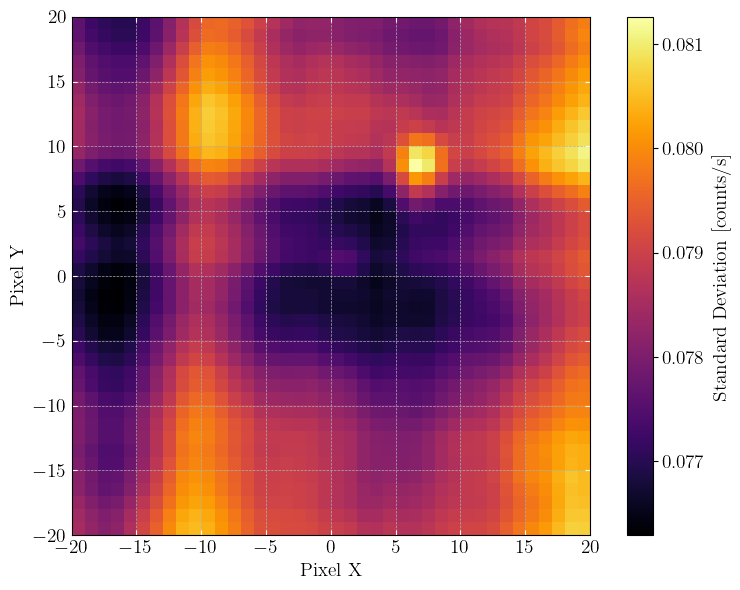

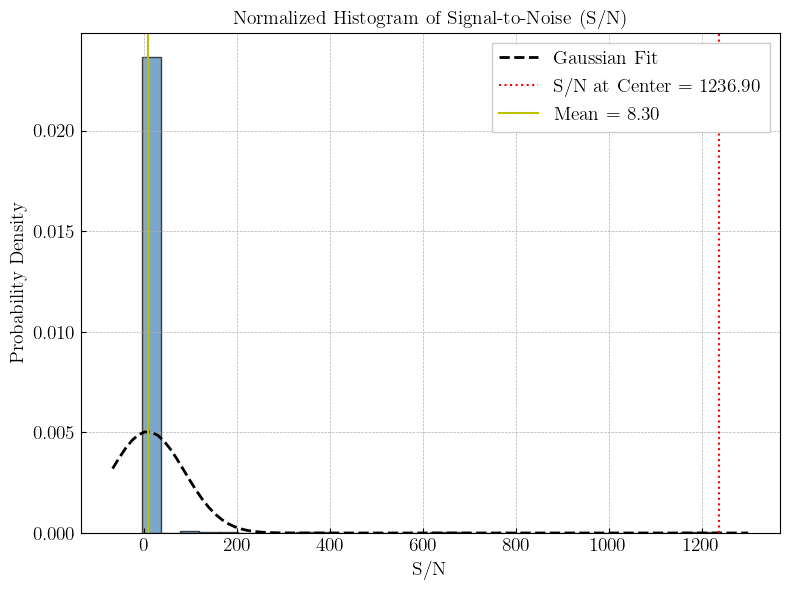

In [45]:
s_flu, s_var, s_expo = stack_crab(dir="../data/Crab/30-60keV/Images", plot=True, statistics=True, save=True, centering=False, quality_control=False) 